In [1]:
# Based on notebook from https://medium.com/@rekalantar/variational-auto-encoder-vae-pytorch-tutorial-dce2d2fe0f5f

In [1]:
#!python -m pip install torchinfo
import torchinfo

In [3]:
import torch
import numpy as np
import torch.nn as nn
from torch.optim import Adam
import matplotlib.pyplot as plt
from torchvision.datasets import MNIST, FashionMNIST
from torch.utils.data import DataLoader
import torchvision.transforms as transforms
from mpl_toolkits.axes_grid1 import ImageGrid
from torchvision.utils import save_image, make_grid

In [6]:
# create a transofrm to apply to each datapoint
transform = transforms.ToTensor()  # transforms.Compose([transforms.ToTensor()])

# download the MNIST datasets
path = "~/datasets"
train_dataset = MNIST(path, transform=transform, download=True)
test_dataset = MNIST(path, transform=transform, download=True)

# create train and test dataloaders
batch_size = 100
train_loader = DataLoader(dataset=train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(dataset=test_dataset, batch_size=batch_size, shuffle=False)

device = torch.device(
    "cuda:0"
    if torch.cuda.is_available()
    else "mps"
    if torch.backends.mps.is_available()
    else "cpu"
)

In [7]:
device

device(type='mps')

In [8]:
# get a batch of images
dataiter = iter(train_loader)
batch_images = next(dataiter)

In [9]:
batch_images[0].shape

torch.Size([100, 1, 28, 28])

In [10]:
# flatten batch
flatten_batch = batch_images[0].view(batch_size, 1 * 28 * 28).to(device)
flatten_batch.shape

torch.Size([100, 784])

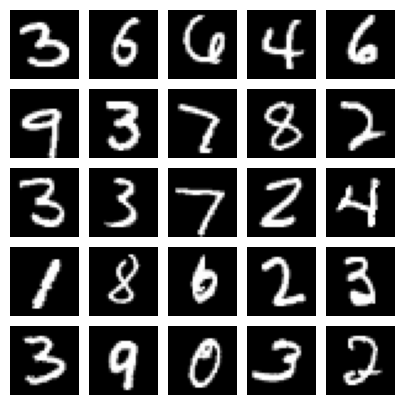

In [11]:
# get 25 sample training images for visualization
num_samples = 25
sample_images = [batch_images[0][i, 0] for i in range(num_samples)]

fig = plt.figure(figsize=(5, 5))
grid = ImageGrid(fig, 111, nrows_ncols=(5, 5), axes_pad=0.1)

for ax, im in zip(grid, sample_images):
    ax.imshow(im, cmap="gray")
    ax.axis("off")

plt.show()

In [8]:
class VAE(nn.Module):
    def __init__(self, input_dim=784, hidden_dim=400, latent_dim=200, z_dim=2):
        super(VAE, self).__init__()

        # encoder
        self.encoder = nn.Sequential(
            nn.Linear(input_dim, hidden_dim),
            nn.LeakyReLU(0.2),
            nn.Linear(hidden_dim, latent_dim),
            nn.LeakyReLU(0.2),
        )

        # latent mean and variance
        self.mean_layer = nn.Linear(latent_dim, z_dim)
        self.logvar_layer = nn.Linear(latent_dim, z_dim)

        # decoder
        self.decoder = nn.Sequential(
            nn.Linear(2, latent_dim),
            nn.LeakyReLU(0.2),
            nn.Linear(latent_dim, hidden_dim),
            nn.LeakyReLU(0.2),
            nn.Linear(hidden_dim, input_dim),
            nn.Sigmoid(),
        )

    def encode(self, x):
        x = self.encoder(x)
        mean, logvar = self.mean_layer(x), self.logvar_layer(x)
        return mean, logvar

    def reparameterization(self, mean, sdev):
        epsilon = torch.randn_like(sdev)
        z = mean + sdev * epsilon
        return z

    def decode(self, x):
        return self.decoder(x)

    def forward(self, x):
        mean, logvar = self.encode(x)
        sdev = torch.exp(0.5 * logvar)  # sdev = sqrt(var)
        z = self.reparameterization(mean, sdev)
        x_hat = self.decode(z)
        return x_hat, mean, logvar

In [9]:
model = VAE().to(device)
optimizer = Adam(model.parameters(), lr=1e-3)

In [10]:
torchinfo.summary(
    model, input_size=(100, 784), col_names=("input_size", "output_size", "num_params")
)

Layer (type:depth-idx)                   Input Shape               Output Shape              Param #
VAE                                      [100, 784]                [100, 784]                --
├─Sequential: 1-1                        [100, 784]                [100, 200]                --
│    └─Linear: 2-1                       [100, 784]                [100, 400]                314,000
│    └─LeakyReLU: 2-2                    [100, 400]                [100, 400]                --
│    └─Linear: 2-3                       [100, 400]                [100, 200]                80,200
│    └─LeakyReLU: 2-4                    [100, 200]                [100, 200]                --
├─Linear: 1-2                            [100, 200]                [100, 2]                  402
├─Linear: 1-3                            [100, 200]                [100, 2]                  402
├─Sequential: 1-4                        [100, 2]                  [100, 784]                --
│    └─Linear: 2-5      

In [16]:
def loss_function(x, x_hat, mean, logvar):
    reproduction_loss = nn.functional.binary_cross_entropy(x_hat, x, reduction="sum")
    KLD = -0.5 * torch.sum(1 + logvar - mean.pow(2) - logvar.exp())
    return reproduction_loss + KLD

In [12]:
def train(model, optimizer, epochs, x_dim=784):
    model.train()
    for epoch in range(epochs):
        overall_loss = 0
        for batch_idx, (x, _) in enumerate(train_loader):
            x = x.view(batch_size, x_dim).to(device)

            optimizer.zero_grad()

            x_hat, mean, log_var = model(x)
            loss = loss_function(x, x_hat, mean, log_var).to(device)

            overall_loss += loss.item()

            loss.backward()
            optimizer.step()

        print(
            "\tEpoch",
            epoch + 1,
            "\tAverage Loss: ",
            overall_loss / (batch_idx * batch_size),
        )
    return overall_loss

In [13]:
train(model.to(device), optimizer, epochs=25)

	Epoch 1 	Average Loss:  180.86672509195012
	Epoch 2 	Average Loss:  162.59514863639922
	Epoch 3 	Average Loss:  157.83040686300083
	Epoch 4 	Average Loss:  155.2680607164284
	Epoch 5 	Average Loss:  153.39977925448665
	Epoch 6 	Average Loss:  151.90826258282033
	Epoch 7 	Average Loss:  150.77570863548624
	Epoch 8 	Average Loss:  149.77993664571162
	Epoch 9 	Average Loss:  149.0349522478871
	Epoch 10 	Average Loss:  148.1881061860914
	Epoch 11 	Average Loss:  147.58248778889293
	Epoch 12 	Average Loss:  147.03530734818446
	Epoch 13 	Average Loss:  146.50104096019408
	Epoch 14 	Average Loss:  146.00386850806032
	Epoch 15 	Average Loss:  145.7070421894564
	Epoch 16 	Average Loss:  145.3445332552953
	Epoch 17 	Average Loss:  144.95954510773163
	Epoch 18 	Average Loss:  144.6683034060674
	Epoch 19 	Average Loss:  144.36089432909014
	Epoch 20 	Average Loss:  143.946006315865
	Epoch 21 	Average Loss:  143.77189542792675
	Epoch 22 	Average Loss:  143.65899537966925
	Epoch 23 	Average Loss:  1

8564853.440429688

In [ ]:
torch.save(model, 'vae.pt')

In [14]:
def generate_digit(z_dim=2):
    z_sample = torch.randn(size=(1, z_dim)).to(device)
    x_decoded = model.decode(z_sample)
    digit = x_decoded.detach().cpu().reshape(28, 28)  # reshape vector to 2d array
    plt.title(f"[{z_sample[0,0]},{z_sample[0,1]}]")
    plt.imshow(digit, cmap="gray")
    plt.axis("off")
    plt.show()

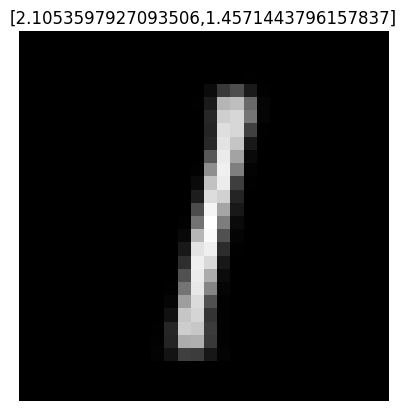

In [15]:
generate_digit()

In [16]:
def plot_latent_space(model, scale=5.0, n=25, digit_size=28, figsize=15):
    # display a n*n 2D manifold of digits
    figure = np.zeros((digit_size * n, digit_size * n))

    # construct a grid
    grid_x = np.linspace(-scale, scale, n)
    grid_y = np.linspace(-scale, scale, n)[::-1]

    for i, yi in enumerate(grid_y):
        for j, xi in enumerate(grid_x):
            z_sample = torch.tensor([[xi, yi]], dtype=torch.float).to(device)
            x_decoded = model.decode(z_sample)
            digit = x_decoded[0].detach().cpu().reshape(digit_size, digit_size)
            figure[
                i * digit_size : (i + 1) * digit_size,
                j * digit_size : (j + 1) * digit_size,
            ] = digit

    plt.figure(figsize=(figsize, figsize))
    plt.title("VAE Latent Space Visualization")
    start_range = digit_size // 2
    end_range = n * digit_size + start_range
    pixel_range = np.arange(start_range, end_range, digit_size)
    sample_range_x = np.round(grid_x, 1)
    sample_range_y = np.round(grid_y, 1)
    plt.xticks(pixel_range, sample_range_x)
    plt.yticks(pixel_range, sample_range_y)
    plt.xlabel("z[0]")
    plt.ylabel("z[1]")
    plt.imshow(figure, cmap="Greys_r")
    plt.show()

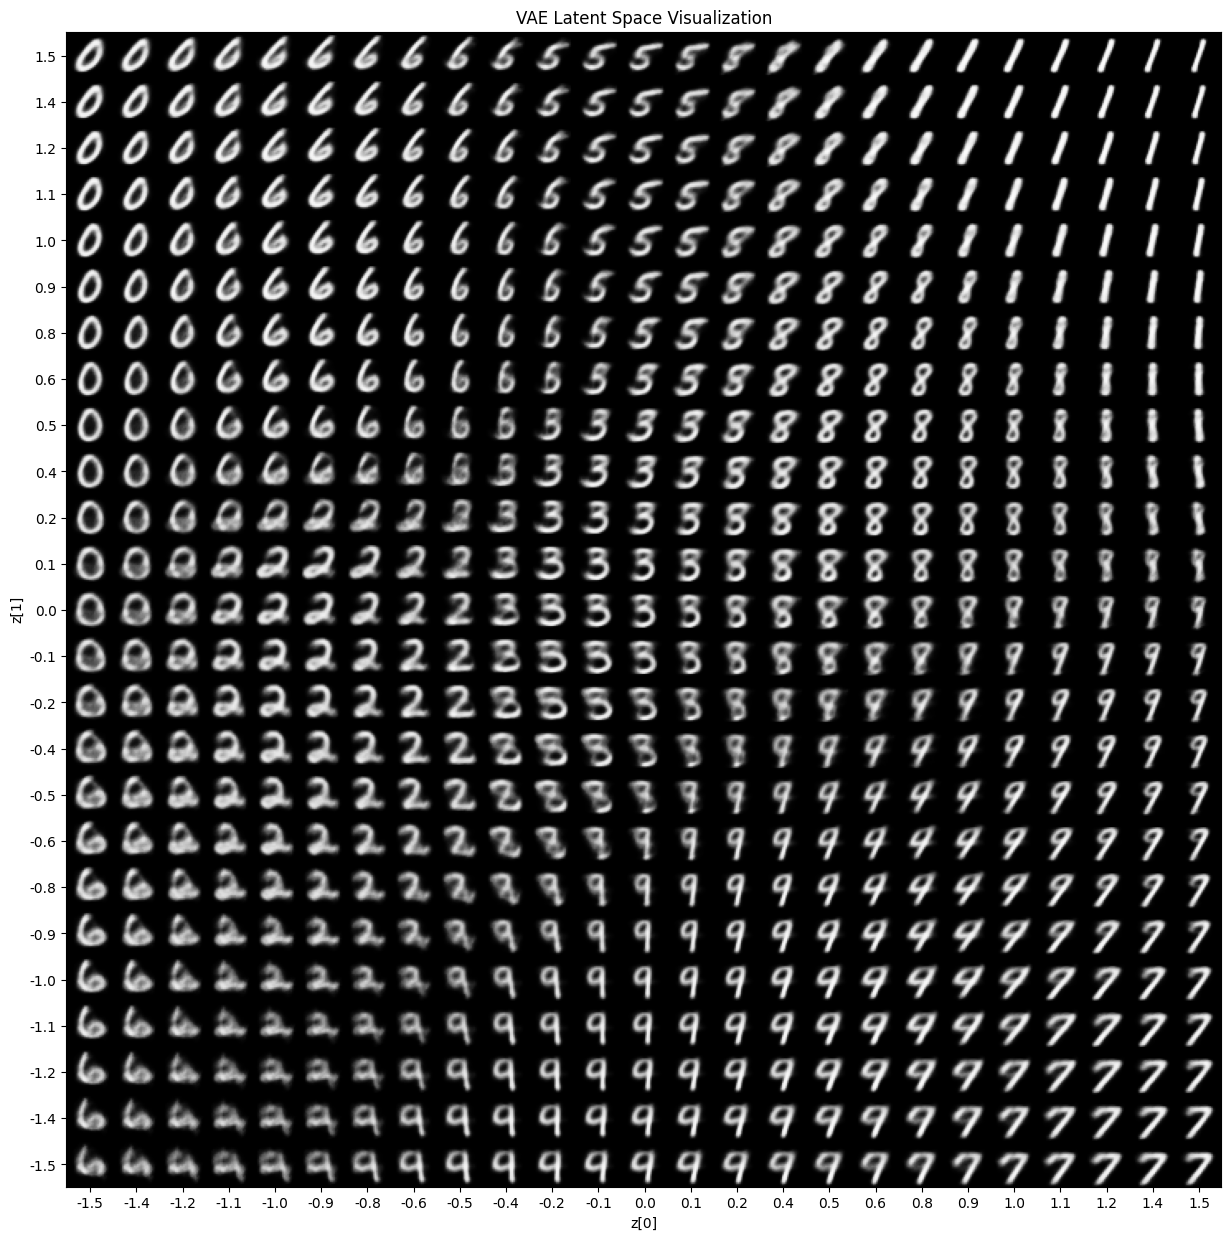

In [17]:
plot_latent_space(model, scale=1.5)

In [12]:
class ConditionalVAE(nn.Module):
    def __init__(self, input_dim=784, hidden_dim=400, latent_dim=200, z_dim=2):
        super(ConditionalVAE, self).__init__()

        # encoder
        self.encoder = nn.Sequential(
            nn.Linear(input_dim + 1, hidden_dim),
            nn.LeakyReLU(0.2),
            nn.Linear(hidden_dim, latent_dim),
            nn.LeakyReLU(0.2),
        )

        # latent mean and variance
        self.mean_layer = nn.Linear(latent_dim, z_dim)
        self.logvar_layer = nn.Linear(latent_dim, z_dim)

        # decoder
        self.decoder = nn.Sequential(
            nn.Linear(z_dim + 1, latent_dim),
            nn.LeakyReLU(0.2),
            nn.Linear(latent_dim, hidden_dim),
            nn.LeakyReLU(0.2),
            nn.Linear(hidden_dim, input_dim),
            nn.Sigmoid(),
        )

    def encode(self, x, y):
        x = self.encoder(torch.cat([x, y], dim=1))
        mean, logvar = self.mean_layer(x), self.logvar_layer(x)
        return mean, logvar

    def reparameterization(self, mean, sdev):
        epsilon = torch.randn_like(sdev)
        z = mean + sdev * epsilon
        return z

    def decode(self, x, y):
        return self.decoder(torch.cat([x, y], dim=1))

    def forward(self, x, y):
        mean, logvar = self.encode(x, y)
        sdev = torch.exp(0.5 * logvar)  # sdev = sqrt(var)
        z = self.reparameterization(mean, sdev)
        x_hat = self.decode(z, y)
        return x_hat, mean, logvar

In [13]:
model_cond = ConditionalVAE().to(device)
optimizer_cond = Adam(model_cond.parameters(), lr=1e-3)

In [14]:
def train_conditional(model, optimizer, epochs, x_dim=784):
    model.train()
    for epoch in range(epochs):
        overall_loss = 0
        for batch_idx, (x, y) in enumerate(train_loader):
            x = x.view(batch_size, x_dim).to(device)
            y = torch.unsqueeze(y, 1).to(device)
            optimizer.zero_grad()

            x_hat, mean, log_var = model(x, y)
            loss = loss_function(x, x_hat, mean, log_var).to(device)

            overall_loss += loss.item()

            loss.backward()
            optimizer.step()

        print(
            "\tEpoch",
            epoch + 1,
            "\tAverage Loss: ",
            overall_loss / (batch_idx * batch_size),
        )
    return overall_loss

In [17]:
train_conditional(model_cond.to(device), optimizer_cond, epochs=25)

	Epoch 1 	Average Loss:  175.07821271128964
	Epoch 2 	Average Loss:  153.36736794396913
	Epoch 3 	Average Loss:  147.8225833746348


8854572.744140625

In [ ]:
torch.save(model_cond, 'cvae.pt')

In [22]:
def generate_digit_cond(digit_class, z_dim=2):
    z_sample = torch.randn(size=(1, z_dim)).to(device)
    z_class_sample = torch.unsqueeze(torch.tensor([digit_class]), dim=1).to(device)
    x_decoded = model_cond.decode(z_sample, z_class_sample)
    digit = x_decoded.detach().cpu().reshape(28, 28)  # reshape vector to 2d array
    plt.title(f"[{z_sample[0,0]},{z_sample[0,1]}]")
    plt.imshow(digit, cmap="gray")
    plt.axis("off")
    plt.show()

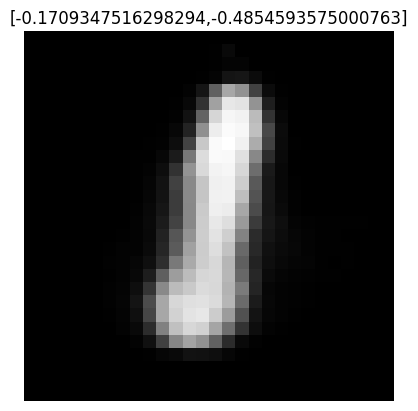

In [26]:
generate_digit_cond(1)

In [18]:
def plot_digit(digit_class, z_dim=2):
    z_sample = torch.randn(size=(1, z_dim)).to(device)
    z_class_sample = torch.unsqueeze(torch.tensor([digit_class]), dim=1).to(device)
    x_decoded = model_cond.decode(z_sample, z_class_sample)
    digit = x_decoded.detach().cpu().reshape(28, 28)
    return digit

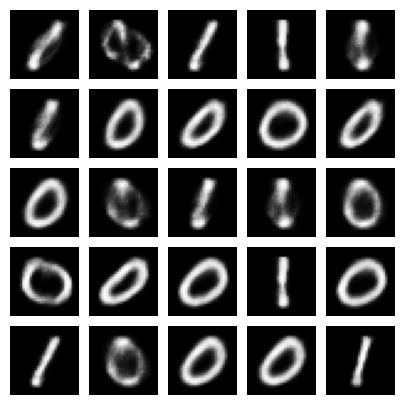

In [21]:
num_samples = 25
class_num = 0
sample_images = [plot_digit(class_num) for _ in range(num_samples)]

fig = plt.figure(figsize=(5, 5))
grid = ImageGrid(fig, 111, nrows_ncols=(5, 5), axes_pad=0.1)

for ax, im in zip(grid, sample_images):
    ax.imshow(im, cmap="gray")
    ax.axis("off")

plt.show()